In [ ]:
# per https://machinelearningmastery.com/use-dropout-lstm-networks-time-series-forecasting/  ,
# definitely best to try the different combinations.

In [1]:
from importlib import reload
import os
import pandas as pd
from io import StringIO
import itertools
import ipdb
import datetime
from collections import Counter

import h5py
import json
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import joblib
print(tf.__version__)

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM

from keras.callbacks import EarlyStopping
from tensorflow.compat.v1.losses import sparse_softmax_cross_entropy

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import mytf.s3utils as msu
import mytf.utils as mu
import mytf.validation as mv
import mytf.plot as mp

1.14.0


Using TensorFlow backend.


In [2]:
tf.enable_eager_execution()

In [3]:
datadir = 'history/2020-02-03T000055Z'
ts = mu.quickts(); print('starting,', ts)

workdir = f'history/{ts}'
os.mkdir(workdir)
print(f'Made new workdir, {workdir}')
os.listdir(workdir)

starting, 2020-02-16T035758Z
Made new workdir, history/2020-02-16T035758Z


[]

In [4]:
lstm_params = [{
    'units': 64,
    'dropout': 0.2,
    'recurrent_dropout': 0.2,
    'batch_input_shape': (None, 64, 8),
    'kernel_initializer': tf.initializers.glorot_normal() # GlorotNormal()
                           #tf.initializers.he_normal()
    },]

optimizer_params = {
    'learning_rate': 0.001,  
    'beta1': 0.9, 
    'beta2': 0.999, 
    'epsilon': 1e-08
}

def bake_model(lstm_params):
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(**lstm_params[0]),
        # 4 because 'A', 'B', 'C', 'D'.
        tf.keras.layers.Dense(4)])
    return model

In [5]:
BATCH_SIZE = 32
EPOCHS = 2
#
print('datadir', datadir, 'workdir', workdir)
train_shuff_loc = f'{datadir}/train_scaled_balanced_shuffled.h5'

X, Ylabels = mu.read_h5_two(
                source_location=train_shuff_loc, 
                Xdataset=f'X',
                Ydataset=f'Ylabels')
size = X.shape[0]

# save base unfitted model.
model = bake_model(lstm_params)
mu.save_model(model=model, 
              loc=f'{workdir}/00000__unfitted_model.h5')

datadir history/2020-02-03T000055Z workdir history/2020-02-16T035758Z


In [6]:
%%time
modelloc = f'{workdir}/00000__unfitted_model.h5'
print(f'Start train with {modelloc}')
model = mu.load_model(modelloc)

class_weights = {0: 1., 1: 0., 2: 0., 3: 0.}
dataset_batches = mu.build_dataset_weighty_v3(
        {'x_train': X,
         'ylabels_train': Ylabels.astype('int64')},
        list(range(size)), 
        class_weights,
        batch_size=BATCH_SIZE)
    
mu.do_train(
        model,
        dataset_batches,
        k=size,
        num_epochs=EPOCHS,
        optimizer_params=optimizer_params,
        saveloc=workdir)


Start train with history/2020-02-16T035758Z/00000__unfitted_model.h5


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




CPU times: user 23min 48s, sys: 1.5 s, total: 23min 49s
Wall time: 23min 47s



### Validation

In [7]:
test_loc = f'{datadir}/test_balanced.h5'
print('test_loc', mu.h5_keys(test_loc))

test_loc ['X_0', 'X_1', 'X_2', 'X_3', 'Ylabels_0', 'Ylabels_1', 'Ylabels_2', 'Ylabels_3']


In [8]:

modelnames_vec = []
for epoch in range(EPOCHS):
    for batch in list(np.arange(0, 1760, 200)) + [1760]:
        step = batch
        prefix = (f'{workdir}/epoch_{str(epoch).zfill(3)}'
                               f'_batch_{str(batch).zfill(5)}')

        modelname = f'{prefix}_model.h5'
        print(modelname, os.path.exists(modelname))
        modelnames_vec.append(prefix)
print('modelnames_vec', modelnames_vec)

history/2020-02-16T035758Z/epoch_000_batch_00000_model.h5 True
history/2020-02-16T035758Z/epoch_000_batch_00200_model.h5 True
history/2020-02-16T035758Z/epoch_000_batch_00400_model.h5 True
history/2020-02-16T035758Z/epoch_000_batch_00600_model.h5 True
history/2020-02-16T035758Z/epoch_000_batch_00800_model.h5 True
history/2020-02-16T035758Z/epoch_000_batch_01000_model.h5 True
history/2020-02-16T035758Z/epoch_000_batch_01200_model.h5 True
history/2020-02-16T035758Z/epoch_000_batch_01400_model.h5 True
history/2020-02-16T035758Z/epoch_000_batch_01600_model.h5 True
history/2020-02-16T035758Z/epoch_000_batch_01760_model.h5 True
history/2020-02-16T035758Z/epoch_001_batch_00000_model.h5 True
history/2020-02-16T035758Z/epoch_001_batch_00200_model.h5 True
history/2020-02-16T035758Z/epoch_001_batch_00400_model.h5 True
history/2020-02-16T035758Z/epoch_001_batch_00600_model.h5 True
history/2020-02-16T035758Z/epoch_001_batch_00800_model.h5 True
history/2020-02-16T035758Z/epoch_001_batch_01000_model.

  0%|          | 0/20 [00:00<?, ?it/s]

starting validation 2020-02-16T043641Z
test_loc history/2020-02-03T000055Z/test_balanced.h5
history/2020-02-16T035758Z/epoch_000_batch_00000_model.h5 True


  5%|▌         | 1/20 [04:51<1:32:22, 291.70s/it]

history/2020-02-16T035758Z/epoch_000_batch_00200_model.h5 True


 10%|█         | 2/20 [09:44<1:27:34, 291.91s/it]

history/2020-02-16T035758Z/epoch_000_batch_00400_model.h5 True


 15%|█▌        | 3/20 [14:35<1:22:38, 291.65s/it]

history/2020-02-16T035758Z/epoch_000_batch_00600_model.h5 True


 20%|██        | 4/20 [19:27<1:17:50, 291.93s/it]

history/2020-02-16T035758Z/epoch_000_batch_00800_model.h5 True


 25%|██▌       | 5/20 [24:20<1:13:04, 292.27s/it]

history/2020-02-16T035758Z/epoch_000_batch_01000_model.h5 True


 30%|███       | 6/20 [29:13<1:08:15, 292.52s/it]

history/2020-02-16T035758Z/epoch_000_batch_01200_model.h5 True


 35%|███▌      | 7/20 [34:08<1:03:29, 293.07s/it]

history/2020-02-16T035758Z/epoch_000_batch_01400_model.h5 True


 40%|████      | 8/20 [39:03<58:43, 293.64s/it]  

history/2020-02-16T035758Z/epoch_000_batch_01600_model.h5 True


 45%|████▌     | 9/20 [43:55<53:44, 293.12s/it]

history/2020-02-16T035758Z/epoch_000_batch_01760_model.h5 True


 50%|█████     | 10/20 [48:47<48:48, 292.84s/it]

history/2020-02-16T035758Z/epoch_001_batch_00000_model.h5 True


 55%|█████▌    | 11/20 [53:41<43:58, 293.21s/it]

history/2020-02-16T035758Z/epoch_001_batch_00200_model.h5 True


 60%|██████    | 12/20 [58:32<39:00, 292.62s/it]

history/2020-02-16T035758Z/epoch_001_batch_00400_model.h5 True


 65%|██████▌   | 13/20 [1:03:24<34:05, 292.25s/it]

history/2020-02-16T035758Z/epoch_001_batch_00600_model.h5 True


 70%|███████   | 14/20 [1:08:15<29:12, 292.08s/it]

history/2020-02-16T035758Z/epoch_001_batch_00800_model.h5 True


 75%|███████▌  | 15/20 [1:13:08<24:20, 292.17s/it]

history/2020-02-16T035758Z/epoch_001_batch_01000_model.h5 True


 80%|████████  | 16/20 [1:17:59<19:27, 291.92s/it]

history/2020-02-16T035758Z/epoch_001_batch_01200_model.h5 True


 85%|████████▌ | 17/20 [1:22:51<14:35, 291.86s/it]

history/2020-02-16T035758Z/epoch_001_batch_01400_model.h5 True


 90%|█████████ | 18/20 [1:27:44<09:44, 292.43s/it]

history/2020-02-16T035758Z/epoch_001_batch_01600_model.h5 True


 95%|█████████▌| 19/20 [1:32:35<04:51, 291.92s/it]

history/2020-02-16T035758Z/epoch_001_batch_01760_model.h5 True


100%|██████████| 20/20 [1:37:31<00:00, 292.56s/it]

done validation 2020-02-16T061412Z


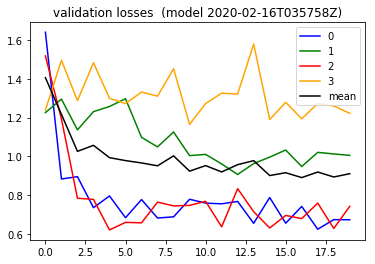

In [9]:
print('starting validation', mu.quickts())
batch_losses_vec = []
print('test_loc', test_loc)
epoch = 0
for step, prefix in enumerate(tqdm(modelnames_vec)):
    # prefix = (f'{workdir}/epoch_{str(epoch).zfill(3)}'
    #                        f'_batch_{str(batch).zfill(5)}')

    modelname = f'{prefix}_model.h5'
    print(modelname, os.path.exists(modelname))

    steploss = mv.perf_wrapper(modelname,
                               dataloc=test_loc,
                               eager=True,
                              batch_size=32)
    batch_losses_vec.append([float(x) for x in steploss])
    mu.to_json_local({'batch_losses_vec': batch_losses_vec,
                  'step': int(step)
              }, 
              f'{prefix}_validation_losses.json')
    
print('done validation', mu.quickts())
#####
lossesarr = np.array(batch_losses_vec)
meanlossesarr = np.mean(lossesarr, axis=1)

batch_losses_vec[:5]
#batch_losses_vec = []

plt.plot([x[0] for x in batch_losses_vec], color='blue', label='0')
plt.plot([x[1] for x in batch_losses_vec], color='green', label='1')
plt.plot([x[2] for x in batch_losses_vec], color='red', label='2')
plt.plot([x[3] for x in batch_losses_vec], color='orange', label='3')
plt.plot(meanlossesarr, color='black', label='mean')
plt.title(f'validation losses  (model {ts})')
plt.legend()     
        

In [ ]:
meanlossesarr